<a href="https://colab.research.google.com/github/ivanzvonkov/visualizing-activations/blob/main/visualizing_activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q fastbook

In [2]:
from fastbook import *

# Load in Dataset

In [3]:
path = untar_data(URLs.IMAGENETTE_160)

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms())

In [5]:
dls = DataLoaders.from_dblock(dblock, path, bs=64)
len(dls.train_ds), len(dls.valid_ds)

(10716, 2678)

# Train Model

In [6]:
learn = cnn_learner(dls, vgg13_bn, metrics=accuracy)

In [7]:
learn.fine_tune(freeze_epochs=1, epochs=0)

epoch,train_loss,valid_loss,accuracy,time
0,0.482679,0.180805,0.943241,02:37


# Explore Activations

In [8]:
batch = dls.valid.one_batch()
batch[0].shape

torch.Size([64, 3, 128, 128])

In [9]:
def display_batch(b, rgb=True, sort_by_func=None, num_display=9, idx_order=None):
  """ Displays some number of items from the batch """
  if type(b) == np.ndarray:
    b_np = b
  else:
    b_np = b.cpu().detach().numpy()

  if rgb and b_np.shape[1] == 3:
    b_np = np.moveaxis(b_np, 1,3)

  nrows = num_display//3
  fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(10,10))

  if idx_order == None:
    idx_order = range(num_display)

  for i in range(num_display):
    if nrows == 1:
      ax[i%3].imshow(b_np[idx_order[i]])
    else:
      ax[i//3][i%3].imshow(b_np[idx_order[i]])

In [51]:
def get_images_and_activations(batch, a_class=None, a_layer=None, 
                   a_channel=None, a_coords=None):
  if type(a_class) == int:
    class_acts_tensor = learn.model.forward(batch[0])
    class_acts = class_acts_tensor.cpu().detach().numpy()
    idx_order = np.where(class_acts.argmax(axis=1) == a_class)
    activations = class_acts
  elif type(a_layer) == int:
    layer_acts_tensor = learn.model[0][0][:a_layer+1].forward(batch[0])
    layer_acts = layer_acts_tensor.cpu().detach().numpy()
    if type(a_channel) == int:
      channel_acts = layer_acts[:, a_channel]
      if type(a_coords) == tuple:
        coords_acts = channel_acts[:, a_coords[0], a_coords[1]]
        idx_order = np.argsort(coords_acts)
      else:
        idx_order = np.argsort(channel_acts.mean(axis=(-1, -2)))
        activations = channel_acts
    else:
      idx_order = np.argsort(layer_acts.mean(axis=(1,2,3)))
      activations = layer_acts.mean(axis=1)

    idx_order = list(idx_order[::-1])
  
  ordered_activations = activations[idx_order]
  print(ordered_activations.shape)

  images = batch[0][idx_order]
  labels = batch[1][idx_order]
  ordered_batch = (images, labels)

  return ordered_batch, ordered_activations

# Generating images

In [11]:
def generate_gaussian_filter(channels=3, kernel_size=15, sigma=0.5):
  """ Gaussian Kernel for blurring """
  
  assert kernel_size%2 == 1, 'Please use odd kernel size'

  # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
  x_cord = torch.arange(kernel_size, device=torch.device(0))
  x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
  y_grid = x_grid.t()
  xy_grid = torch.stack([x_grid, y_grid], dim=-1)

  mean = (kernel_size - 1)/2.
  variance = sigma**2.

  # Calculate the 2-dimensional gaussian kernel which is
  # the product of two gaussian distributions for two different
  # variables (in this case called x and y)
  gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1)/(2*variance)
                    )
  # Make sure sum of values in gaussian kernel equals 1.
  gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

  # Reshape to 2d depthwise convolutional weight
  gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
  gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

  gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                              kernel_size=kernel_size, groups=channels, 
                              bias=False, padding=int((kernel_size-1)/2))

  gaussian_filter.weight.data = gaussian_kernel
  gaussian_filter.weight.requires_grad = False

  return gaussian_filter

In [12]:
def optimize_batch(b, lr=0.1, a_class=None, a_layer=None, a_channel=None, 
                   a_coords=None, lamb=1e-6):
  """ Optimize batch by using lack of activation as the loss """ 
  if type(a_class) == int:
    class_activations = learn.model.forward(b)
    loss = - class_activations[:, a_class].sum() 
  elif type(a_layer) == int:
    layer_activations = learn.model[0][0][:a_layer+1].forward(b)
    if type(a_channel) == int:
      channel_activations = layer_activations[:, a_channel]
      if type(a_coords) == tuple:
        coord_activations = channel_activations[:, a_coords[0], 
                                                a_coords[1]]
        loss = - coord_activations
      else:
        loss = - channel_activations.sum() 
    else:
      loss = - layer_activations.sum() 
  
  loss += lamb*b.square().sum()
  loss.backward()

  # Update step
  with torch.no_grad():
    gradient = lr*b.grad
    if gradient.abs().sum() < 1e-8:
      raise Exception('Vanishing gradient')
    b -= gradient
    b.grad.zero_()
  
  return b, loss    

In [13]:
def get_images_batch(batch, pure_noise=True, amount=None):
  images = batch[0]
  if amount:
    images = images[:amount]
  if pure_noise:
    r2 = images.max()
    r1 = images.min()
    with torch.no_grad():
      b = (r2-r1)*torch.rand(images.shape, dtype=torch.float, device=torch.device(0)) + r1
  else:
    b = images

  b.requires_grad = True
  return b

In [22]:
def generate_activation_images(batch, start_lr=0.5, steps=200, sigma=0.5, 
                               kernel_size=21, blur_freq=20, loss_freq=20, 
                               a_class=None, a_layer=None, a_channel=None, 
                               a_coords=None, pure_noise=True, amount=3):
  if type(a_class) == int:
    print(f'Activations for class: {a_class}')
  
  if type(a_layer) == int:
    print(f'Activations for layer: {a_layer} - {learn.model[0][0][a_layer]}')
    if type(a_channel) == int:
      print(f'Specifically channel: {a_channel}')
    if type(a_coords) == tuple:
      print(f'Coordinates: {a_coords}')
      
  lr = start_lr
  b = get_images_batch(batch, pure_noise=pure_noise, amount=amount)
  gaussian_filter = generate_gaussian_filter(sigma=sigma, kernel_size=kernel_size)
  for step in range(steps):
    # Reduce learning rate after half the steps
    if step == int(steps/2):
      lr = start_lr/10
    
    b, loss = optimize_batch(b, lr=lr, lamb=1e-1, a_class=a_class, 
                             a_layer=a_layer, a_channel=a_channel, 
                             a_coords=a_coords)

    if step%blur_freq == 0:
      with torch.no_grad():
        b = gaussian_filter(b)
      b.requires_grad = True
    
    if step%loss_freq == 0:
      print(loss.item())
      
  # Normalize and display batch
  with torch.no_grad():
    r = b.max() - b.min()
    b_norm = (b - b.min()) / r
    display_batch(b_norm, num_display=amount);

## Experiment

In [52]:
a = {
    'a_layer': 5,
    'a_channel': 20
}
ordered_batch, activations = get_images_and_activations(batch, **a)

(64, 128, 128)


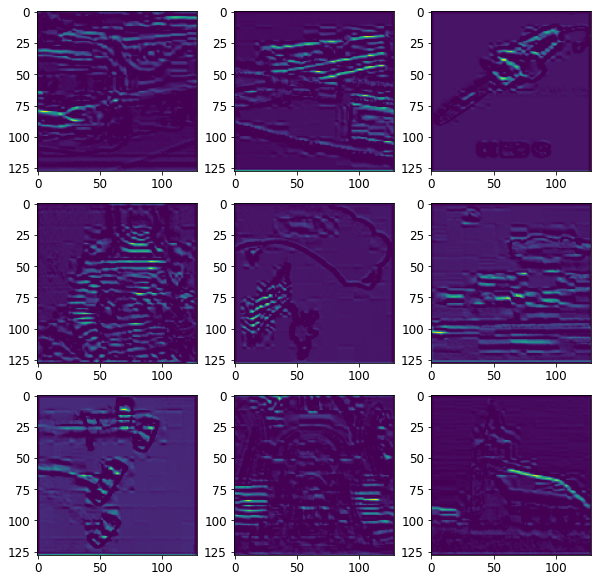

In [53]:
display_batch(activations)

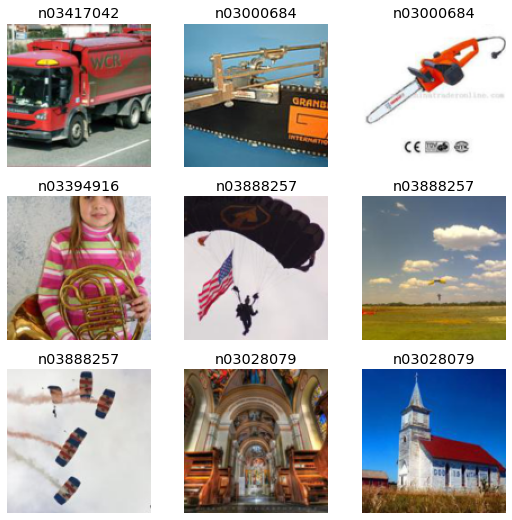

In [54]:
dls.valid.show_batch(b=ordered_batch)

In [94]:
ordered_batch_np = ordered_batch[0].cpu().numpy()
activated_images = np.zeros(shape=ordered_batch_np.shape)
activations_sig = 1/(1 + np.exp(-activations)) 
print(activated_batch.shape)
for channel in range(3):
  activated_images[:, channel] = (ordered_batch_np[:, channel]-4+5*activations_sig)

(64, 3, 128, 128)


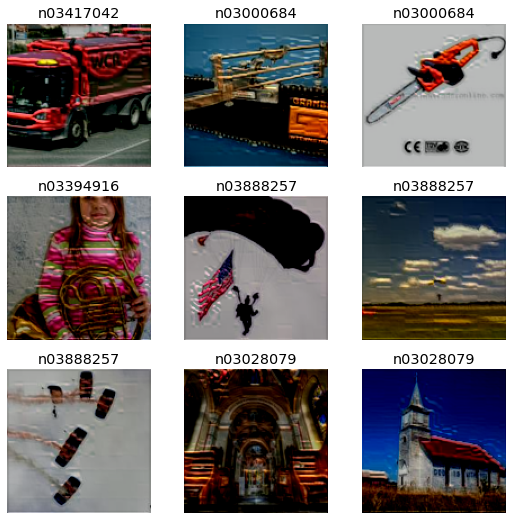

In [95]:
dls.valid.show_batch(b=(activated_images, ordered_batch[1]))

Activations for layer: 5 - ReLU(inplace=True)
Specifically channel: 20
-9811.392578125
-153131.109375
-179564.1875
-188353.71875
-192271.15625
-194181.78125
-102785.375
-69262.5390625
-57094.796875
-52479.1171875


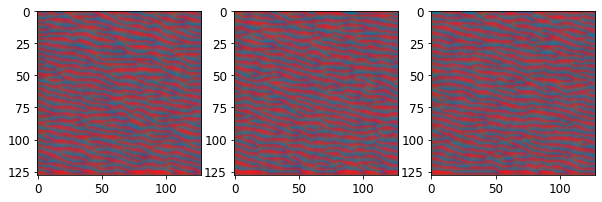

In [45]:
generate_activation_images(batch, amount=3, **a, start_lr=0.1, steps=200, 
                           pure_noise=True, sigma=1)

Activations for class: 4
86470.4140625
508.10833740234375
-60.6761474609375
-150.09039306640625
-176.76861572265625
-241.4176025390625
-1655.2601318359375
-1779.0946044921875
-1829.449462890625
-1880.8590087890625


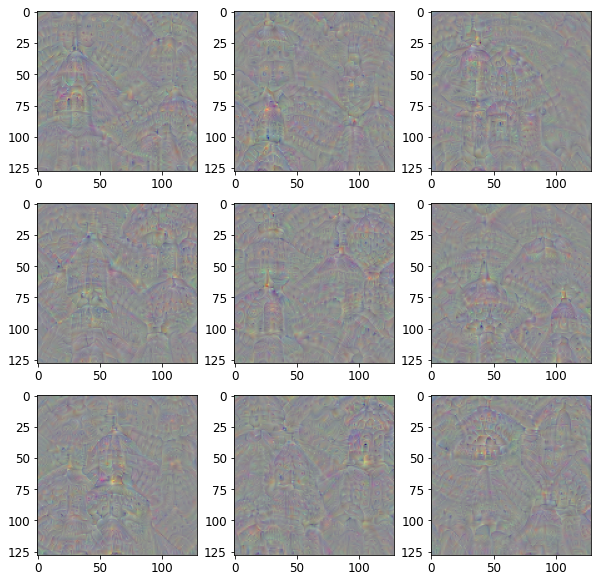

In [98]:
generate_activation_images(batch, amount=9, a_class=4, start_lr=0.5, steps=200)

In [ ]:
# checkout lucent https://github.com/greentfrapp/lucent/tree/master/lucent/optvis/param
# with fft